<a href="https://colab.research.google.com/github/FullPowerMore02/AIPrototype2023/blob/main/LSTMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow pandas numpy matplotlib  yfinance scikit-learn plotly streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
Instructions for updating:
non-resource variables are not supported in the long term
[*********************100%%**********************]  1 of 1 completed
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically

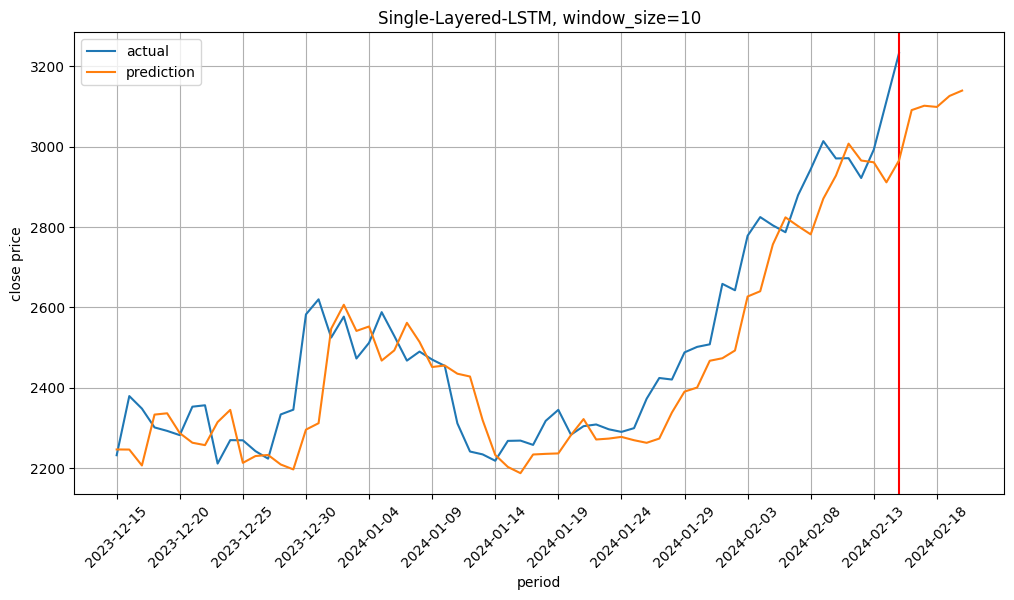

34.73.116.181



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.116.181:8501

npx: installed 22 in 5.243s
your url is: https://public-cows-knock.loca.lt
/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
2024-02-27 02:18:57.945150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 02:18:57.945205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 02:18:57.947586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unab

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
tf.compat.v1.disable_v2_behavior()
%matplotlib inline

df = yf.download('ETH-USD')
df['Pct_change'] = np.log1p(df['Close'].pct_change())
df['Log Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df['Volatility'] = df['Log Returns'].rolling(window=20).std() * np.sqrt(252)
df['Next_day'] = df['Close'].shift(-1)
df.fillna(0, inplace=True)
model = tf.keras.models.load_model('/content/lstm_model.h5')
lookback = 10
data_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Pct_change', 'Log Returns', 'Volatility']
target_columns = ['Next_day']

df_reset = df.reset_index(drop=True)

X = []
y = []

for i in range(len(df_reset)-lookback):
    X.append(df_reset.loc[i:i+lookback-1, data_columns].values)  # to select only the columns specified in data_columns
    y.append(df_reset.loc[i+lookback, target_columns].values[0])  # select the target value

X = np.array(X)
y = np.array(y)
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1))
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1))
X = X.reshape((X.shape[0], lookback, -1))
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=64)
for train_index, test_index in tscv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
X_train = X_train.reshape((X_train.shape[0], lookback, -1))
X_test = X_test.reshape((X_test.shape[0], lookback, -1))
new_data_point = [ X_test[-1] + 0.002, X_test[-1] + 0.00145,X_test[-1] + 0.006475,X_test[-1] + 0.00893]
X_test_appended = np.append(X_test, new_data_point, axis=0)
df_reset = df.reset_index()
date_values_bi = df_reset['Date'].iloc[test_index].values
date_values_bi = [date[:10] for date in date_values_bi.astype('str')]
date_values_bi = np.array(date_values_bi)
start_date = datetime.strptime(date_values_bi[-1], '%Y-%m-%d')
date_values_list_pred = [start_date + timedelta(days=i) for i in range(1,5)]
date_values_list_pred = [date.strftime('%Y-%m-%d') for date in date_values_list_pred ]
date_values_bi_pred = np.append(date_values_bi,date_values_list_pred)




s_pred = model.predict(X_test)
s_plus_pred = model.predict(X_test_appended)


y_s_pred = y_scaler.inverse_transform(s_pred)
y_s_plus_pred = y_scaler.inverse_transform(s_plus_pred)
y_y_test = y_scaler.inverse_transform(y_test)


plt.figure(figsize=(12, 6))
plt.title('Single-Layered-LSTM, window_size=10')
plt.ylabel('close price')
plt.xlabel('period')
plt.plot(date_values_bi[:-1], y_y_test[:-1], label='actual')
plt.axvline(date_values_bi[-2], color='red')
plt.plot(date_values_bi_pred, y_s_plus_pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.xticks(np.arange(0, len(date_values_bi_pred), step=5), date_values_bi_pred[::5], rotation=45)
plt.show()

! wget -q -O - ipv4.icanhazip.com
! streamlit run app.py & npx localtunnel --port 8501